# Lab — Explainable GNN

Consider the GNNExplainer model — the method for explaining predictions made by GNNs.

In [33]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html -q
import dgl
dgl.__version__

'0.7.2'

### Training GNN on CORA

In [34]:
import dgl
from dgl import utils
from dgl.data import CoraGraphDataset
from dgl.subgraph import node_subgraph
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from tqdm import tqdm
from dgl.base import NID, EID
from collections.abc import Mapping
import networkx as nx
import matplotlib.pyplot as plt


In [35]:
dataset = CoraGraphDataset()
graph = dataset[0]
graph

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [36]:
labels = graph.ndata['label']
labels.shape

torch.Size([2708])

In [37]:
feat = graph.ndata['feat']
feat.shape

torch.Size([2708, 1433])

In [38]:
train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']
val_mask = graph.ndata['val_mask']
train_mask


tensor([False, False, False,  ..., False, False, False])

Here is a simple two-layer GCN.

In [39]:
model = dgl.nn.Sequential(
    dgl.nn.GraphConv(in_feats=1433, out_feats=128, activation=nn.ReLU()),
    dgl.nn.GraphConv(in_feats=128, out_feats=7),
)

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
model.train()
n_epochs = 200
for e in range(1, n_epochs+1):
    logits = model(graph, feat)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e == 1 or e % 10 == 0:
        pred = logits.argmax(dim=1)
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        print(f'Epoch: {e}/{n_epochs}, Train accuracy: {train_acc:.2f}, Validation accuracy: {val_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 1/200, Train accuracy: 0.20, Validation accuracy: 0.15
Epoch: 10/200, Train accuracy: 0.74, Validation accuracy: 0.41
Epoch: 20/200, Train accuracy: 0.86, Validation accuracy: 0.55
Epoch: 30/200, Train accuracy: 0.87, Validation accuracy: 0.57
Epoch: 40/200, Train accuracy: 0.87, Validation accuracy: 0.59
Epoch: 50/200, Train accuracy: 0.89, Validation accuracy: 0.61
Epoch: 60/200, Train accuracy: 0.90, Validation accuracy: 0.64
Epoch: 70/200, Train accuracy: 0.91, Validation accuracy: 0.65
Epoch: 80/200, Train accuracy: 0.92, Validation accuracy: 0.65
Epoch: 90/200, Train accuracy: 0.93, Validation accuracy: 0.67
Epoch: 100/200, Train accuracy: 0.94, Validation accuracy: 0.68
Epoch: 110/200, Train accuracy: 0.94, Validation accuracy: 0.69
Epoch: 120/200, Train accuracy: 0.95, Validation accuracy: 0.71
Epoch: 130/200, Train accuracy: 0.96, Validation accuracy: 0.71
Epoch: 140/200, Train accuracy: 0.96, Validation accuracy: 0.73
Epoch: 150/200, Train accuracy: 0.96, Validation ac

### K-hop computatinal subgraphs

Here is an auixilary method for k-hop subgraph extracting. 

*The code is taken from the latest (not stable) DGL version https://github.com/dmlc/dgl/tree/master.*

In [41]:
def slice_axis(data, axis, begin, end):
    return torch.narrow(data, axis, begin, end - begin)

def khop_in_subgraph(graph, nodes, k, *, relabel_nodes=True, store_ids=True):
    is_mapping = isinstance(nodes, Mapping)
    if not is_mapping:
        assert len(graph.ntypes) == 1, \
            'need a dict of node type and IDs for graph with multiple node types'
        nodes = {graph.ntypes[0]: nodes}

    for nty, nty_nodes in nodes.items():
        nodes[nty] = utils.prepare_tensor(graph, nty_nodes, 'nodes["{}"]'.format(nty))

    last_hop_nodes = nodes
    k_hop_nodes_ = [last_hop_nodes]
    place_holder = torch.tensor([], dtype=graph.idtype).to(graph.device)
    for _ in range(k):
        current_hop_nodes = {nty: [] for nty in graph.ntypes}
        for cetype in graph.canonical_etypes:
            srctype, _, dsttype = cetype
            in_nbrs, _ = graph.in_edges(last_hop_nodes.get(dsttype, place_holder), etype=cetype)
            current_hop_nodes[srctype].append(in_nbrs)
        for nty in graph.ntypes:
            if len(current_hop_nodes[nty]) == 0:
                current_hop_nodes[nty] = place_holder
                continue
            current_hop_nodes[nty] = torch.unique(torch.cat(current_hop_nodes[nty], dim=0))
        k_hop_nodes_.append(current_hop_nodes)
        last_hop_nodes = current_hop_nodes

    k_hop_nodes = dict()
    inverse_indices = dict()
    for nty in graph.ntypes:
        k_hop_nodes[nty], inverse_indices[nty] = torch.unique(torch.cat([
            hop_nodes.get(nty, place_holder)
            for hop_nodes in k_hop_nodes_], dim=0), return_inverse=True)

    sub_g = node_subgraph(graph, k_hop_nodes, relabel_nodes=relabel_nodes, store_ids=store_ids)
    if relabel_nodes:
        if is_mapping:
            seed_inverse_indices = dict()
            for nty in nodes:
                seed_inverse_indices[nty] = slice_axis(
                    inverse_indices[nty], axis=0, begin=0, end=len(nodes[nty]))
        else:
            seed_inverse_indices = slice_axis(
                inverse_indices[nty], axis=0, begin=0, end=len(nodes[nty]))
        return sub_g, seed_inverse_indices
    else:
        return sub_g

Let us build a 1-hop subgraph from the node 1010.

In [42]:
test_mask[1010]

tensor(True)

In [43]:
target_node = 1010
sg, _ = khop_in_subgraph(graph, nodes=target_node, k=1, relabel_nodes=True)

The initail node ids are stored in node features.

In [44]:
sg.nodes()

tensor([0, 1, 2, 3, 4, 5, 6])

In [45]:
sg.ndata[NID]

tensor([ 507,  508,  509,  944, 1010, 1012, 1800])

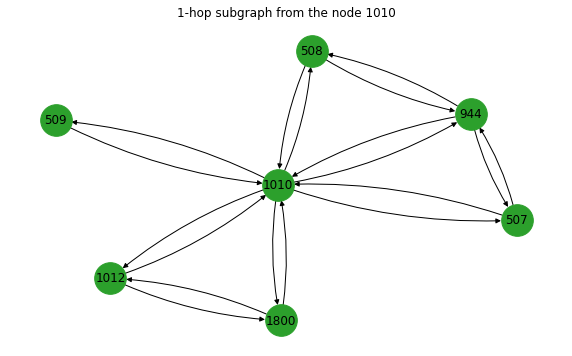

In [46]:
plt.figure(figsize=(10, 6))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
nx.draw_networkx(
    sg.to_networkx(), 
    pos = nx.kamada_kawai_layout(sg.to_networkx()),
    node_size=1000,
    labels=node_ids, 
    connectionstyle='arc3, rad=0.1',
    node_color='tab:green'
)
plt.axis('off')
plt.title(f'1-hop subgraph from the node {target_node}')
plt.show()

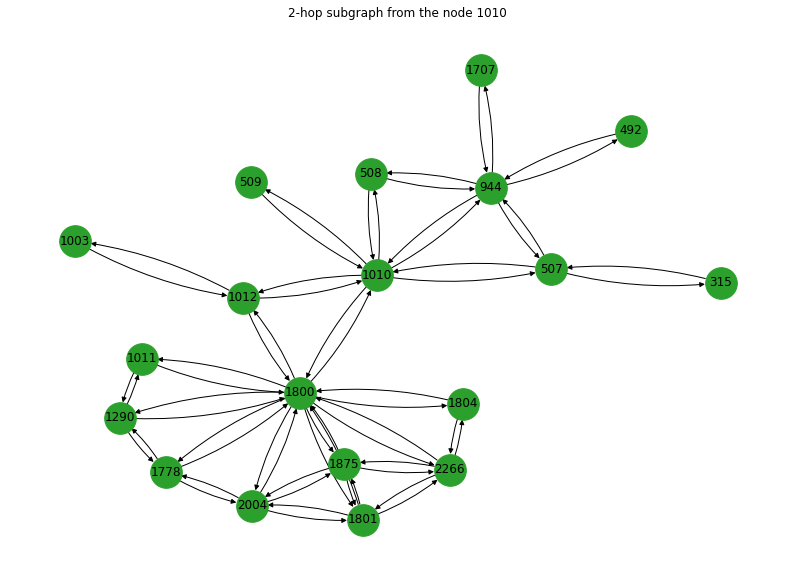

In [47]:
sg, _ = khop_in_subgraph(graph, nodes=target_node, k=2, relabel_nodes=True)
plt.figure(figsize=(14, 10))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
nx.draw_networkx(
    sg.to_networkx(), 
    pos = nx.kamada_kawai_layout(sg.to_networkx()),
    node_size=1000,
    labels=node_ids, 
    connectionstyle='arc3, rad=0.1',
    node_color='tab:green'
)
plt.axis('off')
plt.title(f'2-hop subgraph from the node {target_node}')
plt.show()

### GNNExplainer

Given a trained GNN model $Φ$ and a prediction or a set of predictions, the GNNExplainer will generate an explanation by identifying a subgraph of the computation graph and a subset of node features that are most influential for the model $Φ$’s prediction.

Formulate the GNNExplainer as the following optimization framework:

$$\max _{G_{S}, F} M I\left(Y,\left(G_{S}, F\right)\right)=H(Y)-H\left(Y \mid G=G_{S}, X=X_{S}^{F}\right)$$

The second term can be rewrited as

$$\min _{\mathcal{G}} H\left(Y \mid G=\mathbb{E}_{\mathcal{G}}\left[G_{S}\right], X=X_{S}\right)$$

*The code is taken from the latest (not stable) DGL version https://github.com/dmlc/dgl/tree/master.*

In [48]:
class GNNExplainer(nn.Module):
    coeffs = {
        'edge_size': 0.005,
        'edge_ent': 1.0,
        'node_feat_size': 1.0,
        'node_feat_ent': 0.1
    }
    def __init__(self,
                 model,
                 num_hops,
                 lr=0.01,
                 num_epochs=100,
                 log=True):
        super(GNNExplainer, self).__init__()
        self.model = model
        self.num_hops = num_hops
        self.lr = lr
        self.num_epochs = num_epochs
        self.log = log

    def _init_masks(self, graph, feat):
        
        num_nodes, feat_size = feat.size()
        num_edges = graph.num_edges()
        device = feat.device

        std = 0.1
        feat_mask = nn.Parameter(torch.randn(1, feat_size, device=device) * std)

        std = nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * num_nodes))
        edge_mask = nn.Parameter(torch.randn(num_edges, device=device) * std)

        return feat_mask, edge_mask

    def _loss_regularize(self, loss, feat_mask, edge_mask):
       
        # epsilon for numerical stability
        eps = 1e-15

        edge_mask = edge_mask.sigmoid()
        # Edge mask sparsity regularization
        loss = loss + self.coeffs['edge_size'] * torch.sum(edge_mask)
        # Edge mask entropy regularization
        ent = - edge_mask * torch.log(edge_mask + eps) - \
            (1 - edge_mask) * torch.log(1 - edge_mask + eps)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        feat_mask = feat_mask.sigmoid()
        # Feature mask sparsity regularization
        loss = loss + self.coeffs['node_feat_size'] * torch.mean(feat_mask)
        # Feature mask entropy regularization
        ent = -feat_mask * torch.log(feat_mask + eps) - \
            (1 - feat_mask) * torch.log(1 - feat_mask + eps)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_node(self, node_id, graph, feat, **kwargs):
        
        self.model.eval()
        num_nodes = graph.num_nodes()
        num_edges = graph.num_edges()

        # Extract node-centered k-hop subgraph and
        # its associated node and edge features.
        sg, inverse_indices = khop_in_subgraph(graph, node_id, self.num_hops)
        sg_nodes = sg.ndata[NID].long()
        sg_edges = sg.edata[EID].long()
        feat = feat[sg_nodes]

        # Get the initial prediction.
        with torch.no_grad():
            logits = self.model(sg, feat)
            pred_label = logits.argmax(dim=-1)

        feat_mask, edge_mask = self._init_masks(sg, feat)

        params = [feat_mask, edge_mask]
        optimizer = torch.optim.Adam(params, lr=self.lr)

        if self.log:
            pbar = tqdm(total=self.num_epochs)
            pbar.set_description('Explain node {node_id}')

        for _ in range(self.num_epochs):
            optimizer.zero_grad()
            h = feat * feat_mask.sigmoid()
            logits = self.model(sg, h)
            log_probs = logits.log_softmax(dim=-1)
            loss = -log_probs[inverse_indices, pred_label[inverse_indices]]
            loss = self._loss_regularize(loss, feat_mask, edge_mask)
            loss.backward()
            optimizer.step()

            if self.log:
                pbar.update(1)

        if self.log:
            pbar.close()

        feat_mask = feat_mask.detach().sigmoid().squeeze()
        edge_mask = edge_mask.detach().sigmoid()

        return inverse_indices, sg, feat_mask, edge_mask

Create an explainer object and train explanaition for the target node.

In [49]:
explainer = GNNExplainer(model, num_hops=1, lr=0.001, num_epochs=200, log=True)
new_node_id, sg, feat_mask, edge_mask = explainer.explain_node(
    node_id=target_node, graph=graph, feat=feat
)

Explain node {node_id}:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Explain node {node_id}: 100%|██████████| 200/200 [00:01<00:00, 173.60it/s]


In [50]:
print(new_node_id)
print(sg)
print(feat_mask)
print(edge_mask)

tensor([4])
Graph(num_nodes=7, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([0.4471, 0.4634, 0.4879,  ..., 0.4572, 0.4685, 0.4501])
tensor([0.6000, 0.4017, 0.8003, 0.6453, 0.4387, 0.6246, 0.5992, 0.4201, 0.3408,
        0.4373, 0.3849, 0.4430, 0.4280, 0.4434, 0.6694, 0.2923, 0.1897, 0.6799])


Plot a 1-hop subgraph where edges are colored by their importance to the predicted class of the target node.

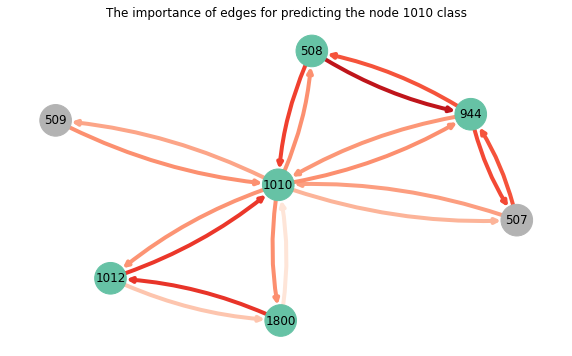

In [51]:
plt.figure(figsize=(10, 6))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
G = sg.to_networkx()
color = sg.ndata['label']
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G, pos=pos, node_size=1000, node_color=color, cmap=plt.cm.Set2
)
nx.draw_networkx_labels(G, pos=pos, labels=node_ids)
nx.draw_networkx_edges(
    G, pos=pos, node_size=1000, width=4,
    edge_color=edge_mask.numpy(), 
    edge_cmap=plt.cm.Reds,
    edge_vmin=0.1, edge_vmax=0.99,
    connectionstyle='arc3, rad=0.1',
)
plt.axis('off')
plt.title(f'The importance of edges for predicting the node {target_node} class')
plt.show()

Let us look at 2-hop subgraph explanations.

In [52]:
explainer = GNNExplainer(model, num_hops=2, lr=0.001, num_epochs=600, log=True)
new_node_id, sg, feat_mask, edge_mask = explainer.explain_node(
    node_id=target_node, graph=graph, feat=feat
)

Explain node {node_id}:   0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Explain node {node_id}: 100%|██████████| 600/600 [00:03<00:00, 169.55it/s]


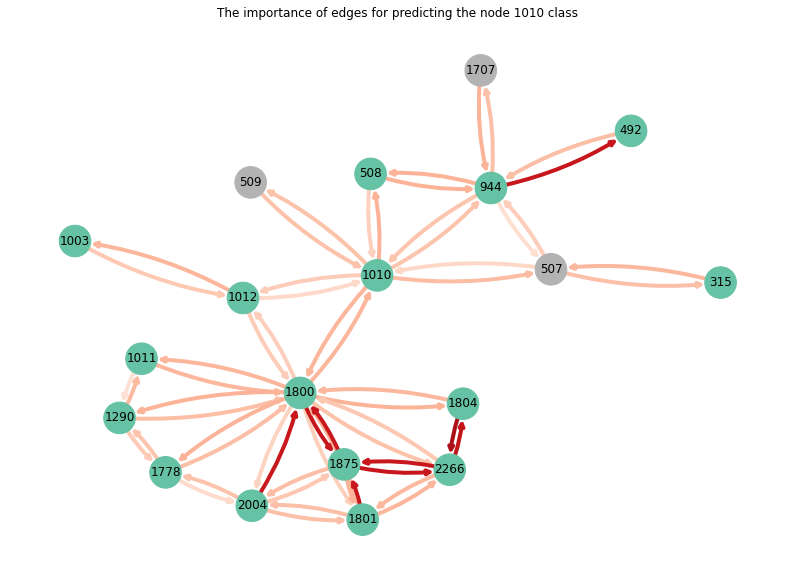

In [53]:
plt.figure(figsize=(14, 10))
node_ids = {i: n.item() for i, n in enumerate(sg.ndata[NID])}
G = sg.to_networkx()
color = sg.ndata['label']
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(
    G, pos=pos, node_size=1000, node_color=color, cmap=plt.cm.Set2
)
nx.draw_networkx_labels(G, pos=pos, labels=node_ids)
nx.draw_networkx_edges(
    G, pos=pos, node_size=1000, width=4,
    edge_color=edge_mask.numpy(), 
    edge_cmap=plt.cm.Reds,
    edge_vmin=0.1, edge_vmax=0.99,
    connectionstyle='arc3, rad=0.1',
)
plt.axis('off')
plt.title(f'The importance of edges for predicting the node {target_node} class')
plt.show()

Let us look at the feature importance.

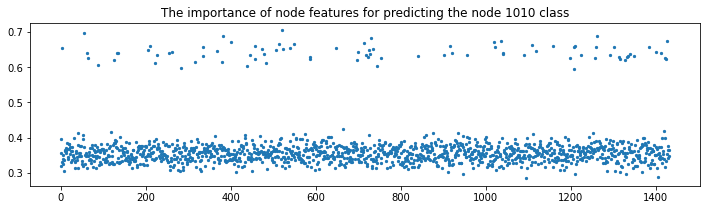

In [54]:
plt.figure(figsize=(12, 3))
plt.scatter(range(1433), feat_mask, s=5)
plt.title(f'The importance of node features for predicting the node {target_node} class')
plt.show()

Let us add the label into train set and check that the importance of such attributes be large.

In [55]:
graph.ndata['feat'].shape

torch.Size([2708, 1433])

In [56]:
F.one_hot(graph.ndata['label']).shape

torch.Size([2708, 7])

Concatenate the last 100 features and new 7-dimensional label matrix.

In [57]:
feat = torch.cat([graph.ndata['feat'][:, -100:], F.one_hot(graph.ndata['label'])], dim=1)
feat.shape

torch.Size([2708, 107])

In [58]:
model = dgl.nn.Sequential(
    dgl.nn.GraphConv(in_feats=107, out_feats=128, activation=nn.ReLU()),
    dgl.nn.GraphConv(in_feats=128, out_feats=7),
)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
model.train()
n_epochs = 500
for e in range(1, n_epochs+1):
    logits = model(graph, feat)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if e == 1 or e % 50 == 0:
        pred = logits.argmax(dim=1)
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        print(f'Epoch: {e}/{n_epochs}, Train accuracy: {train_acc:.2f}, Validation accuracy: {val_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 1/500, Train accuracy: 0.00, Validation accuracy: 0.01
Epoch: 50/500, Train accuracy: 0.98, Validation accuracy: 0.95
Epoch: 100/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 150/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 200/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 250/500, Train accuracy: 0.99, Validation accuracy: 0.93
Epoch: 300/500, Train accuracy: 0.99, Validation accuracy: 0.94
Epoch: 350/500, Train accuracy: 1.00, Validation accuracy: 0.94
Epoch: 400/500, Train accuracy: 1.00, Validation accuracy: 0.94
Epoch: 450/500, Train accuracy: 1.00, Validation accuracy: 0.94
Epoch: 500/500, Train accuracy: 1.00, Validation accuracy: 0.94
Test accuracy: 0.93


In [60]:
explainer = GNNExplainer(model, num_hops=2, lr=0.001, num_epochs=600, log=True)
new_node_id, sg, feat_mask, edge_mask = explainer.explain_node(
    node_id=target_node, graph=graph, feat=feat
)

Explain node {node_id}:   0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Explain node {node_id}: 100%|██████████| 600/600 [00:02<00:00, 201.60it/s]


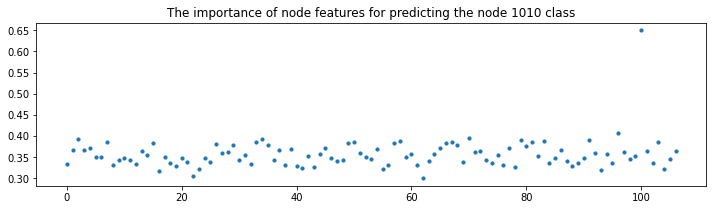

In [61]:
plt.figure(figsize=(12, 3))
plt.scatter(range(107), feat_mask, s=10)
plt.title(f'The importance of node features for predicting the node {target_node} class')
plt.show()

In [62]:
attr = feat_mask.argmax()
print(f'The most important attribute is {attr}')
print(f'The truth label is {labels[target_node]}')

The most important attribute is 100
The truth label is 0


As we see, the true label corresponds to the most important attribute.